In [ ]:
import shutil
shutil.rmtree('./mnist_png/test8/')

In [1]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속도 TPU변경
%tensorflow_version 2.x
#런타임 -> 런타임 다시시작

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import natsort
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.9.2


## 0 이미지로만 구성된 training dataset

In [3]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving training.zip to training.zip
User uploaded file "training.zip" with length 2482527 bytes


## 0 이미지로만 구성된 testing dataset

In [4]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving testing_0.zip to testing_0.zip
User uploaded file "testing_0.zip" with length 408390 bytes


## 8 이미지로만 구성된 testing dataset

In [ ]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving testing.zip to testing.zip
User uploaded file "testing.zip" with length 405114 bytes


## 0, 8 이미지로 구성된 testing dataset

In [5]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving 0_8_mixed.zip to 0_8_mixed.zip
User uploaded file "0_8_mixed.zip" with length 416939 bytes


In [6]:
! mkdir mnist_png
! mkdir mnist_png/train
! mkdir mnist_png/test

In [7]:
! unzip training.zip -d ./mnist_png/train
! unzip testing_0.zip -d ./mnist_png/test0
#! unzip testing.zip -d ./mnist_png/test8
! unzip 0_8_mixed.zip -d ./mnist_png/test0_8

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./mnist_png/train/0/36929.png  
 extracting: ./mnist_png/train/0/3693.png  
 extracting: ./mnist_png/train/0/36937.png  
 extracting: ./mnist_png/train/0/36948.png  
 extracting: ./mnist_png/train/0/36953.png  
 extracting: ./mnist_png/train/0/36975.png  
 extracting: ./mnist_png/train/0/3698.png  
 extracting: ./mnist_png/train/0/36994.png  
 extracting: ./mnist_png/train/0/37.png  
 extracting: ./mnist_png/train/0/3702.png  
 extracting: ./mnist_png/train/0/37027.png  
 extracting: ./mnist_png/train/0/37043.png  
 extracting: ./mnist_png/train/0/37047.png  
 extracting: ./mnist_png/train/0/37052.png  
 extracting: ./mnist_png/train/0/37059.png  
 extracting: ./mnist_png/train/0/37079.png  
 extracting: ./mnist_png/train/0/3709.png  
 extracting: ./mnist_png/train/0/37092.png  
 extracting: ./mnist_png/train/0/37099.png  
 extracting: ./mnist_png/train/0/37113.png  
 extracting: ./mnist_png/train/0/37141.png  
 extracting: ./mnist_png/t

In [9]:
# 압축해제된 데이터 경로
src_train = './mnist_png/train/'
src_test = './mnist_png/test0/'

#이미지 읽기
def img_read(src,file):
  img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
  return img

#src 경로에 있는 이미지 파일 리스트 저장 

# train data
files0 = os.listdir(src_train + str(0))

#test data
files0_test = os.listdir(src_test + str(0))
# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣는다.
# 255로 나눠주는 이유는, 이미지 데이터는 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값을 가지게 되기 때문이다.

# train data
X,Y = [],[]
for file in files0:
    X.append(img_read(src_train + str(0) + '/',file)/255.)
    Y.append(1) # nomal label : 1

# test data
X_test,Y_test = [],[]
for file in files0_test:
    X_test.append(img_read(src_test + str(0) +'/',file)/255.)
    Y_test.append(1) # nomal label : 1

# array로 데이터 변환
X = np.array(X)
Y = np.array(Y)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Train set, Test set으로 나누기
x_train = X
y_train = Y
x_test = X_test
y_test = Y_test
x_train = np.array(x_train)
x_test = np.array(x_test)

 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 변환
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))


Datasets_train_shape:(5923, 784)  Datasets_test_shape:(980, 784)


## Anomaly data로딩(8 이미지로만 구성)

In [ ]:
src_test8 = './mnist_png/test8/'
files8_test = os.listdir(src_test8 + str(8))

# test data
ANom = []
ANom_Y = []

for file in files8_test: 
    ANom.append(img_read(src_test8 + str(8) + '/',file)/255.)
    ANom_Y.append(0) # Anomal label : 0

# array로 데이터 변환
ANom = np.array(ANom)
ANom_Y = np.array(ANom_Y)
print('Anomaly shape:', np.shape(ANom_Y))
# (image,image)이미지를 크기의 (image*image,)크기의 벡터로 변환
ANom_images  = ANom.reshape((len(ANom), np.prod(ANom.shape[1:])))
print(np.shape(ANom_images))

Anomaly shape: (974,)
(974, 784)


## Mixed data로딩

In [10]:
src_test0_8 = './mnist_png/test0_8/'
files0_8_test = os.listdir(src_test0_8 + str(0))
#files0_8_test = natsort.natsorted(files0_8_test)
print(files0_8_test)

# test data
outlier_X = []
outlier_Y = []  # True label

for file in files0_8_test: 
    outlier_X.append(img_read(src_test0_8 + str(0) + '/',file)/255.)
    if "-8" in file:
      outlier_Y.append(0) # Anomal label : 0
    else: 
      outlier_Y.append(1) # Nomal label : 1

# array로 데이터 변환
outlier_X = np.array(outlier_X)
outlier_Y = np.array(outlier_Y)
print('Anomaly shape:', np.shape(outlier_Y))

# (image,image)이미지를 크기의 (image*image,)크기의 벡터로 변환
outlier_images  = outlier_X.reshape((len(outlier_X), np.prod(outlier_X.shape[1:])))
print(np.shape(outlier_images))

['1061.png', '8325.png', '9060.png', '7062.png', '7889.png', '2988.png', '3830.png', '4527.png', '1438.png', '7516.png', '6923.png', '3179.png', '4804.png', '4048.png', '9688.png', '3215.png', '4079.png', '8163.png', '3695.png', '5043.png', '9631.png', '2764.png', '6588.png', '7625.png', '9070.png', '9158.png', '1700.png', '9809.png', '1273.png', '701.png', '5342.png', '567.png', '4614.png', '6250.png', '8481.png', '8895.png', '8748.png', '5519.png', '110-8.png', '2023.png', '4281.png', '7449.png', '1191.png', '1775.png', '5470.png', '4065.png', '2937.png', '5109.png', '4361.png', '3266.png', '9297.png', '8335.png', '101.png', '8055.png', '7655.png', '586.png', '4495.png', '3317.png', '6750.png', '6470.png', '4675.png', '6597.png', '4457.png', '1768.png', '4937.png', '8359.png', '9016.png', '5899.png', '6429.png', '6546.png', '592.png', '8007.png', '6286.png', '5952.png', '2657.png', '8251.png', '4351.png', '5974.png', '6590.png', '9498.png', '1533.png', '4208.png', '9528.png', '4188.p

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.__version__)     # 텐서플로우 버전확인 (colab의 기본버전은 1.15.0) --> 2.0 변경 "%tensorflow_version 2.x"
print(keras.__version__)

2.9.2
2.9.0


## Autoencoder model

In [ ]:
def AE():
    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(Dense(256, input_shape=(28*28,)))  # Input layer
    model.add(Activation('relu'))      

    model.add(Dense(128))                       # Hidden layer1
    model.add(Activation('relu'))

    ## Decoder 구간
    model.add(Dense(128))                        # Hidden layer1
    model.add(Activation('relu'))

    model.add(Dense(28*28))                # Output layer
    model.add(Activation('sigmoid'))
    #model.add(Activation('linear'))

    return model

In [ ]:
def AE():
    ## Encoder 구간
    model = tf.keras.Sequential()
    model.add(Dense(512, input_shape=(28*28,)))  # Input layer + Hidden layer1
    model.add(Activation('relu'))      

    model.add(Dense(256))                       # Hidden layer2
    model.add(Activation('relu'))

    model.add(Dense(128))                       # Hidden layer3
    model.add(Activation('relu'))

    ## Decoder 구간
    model.add(Dense(128))                        # Hidden layer3
    model.add(Activation('relu'))

    model.add(Dense(256))                        # Hidden layer2
    model.add(Activation('relu'))

    model.add(Dense(512))                        # Hidden layer1
    model.add(Activation('relu'))

    model.add(Dense(28*28))                # Output layer
    model.add(Activation('sigmoid'))

    return model

In [ ]:
# model 함수 실행
model = AE()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

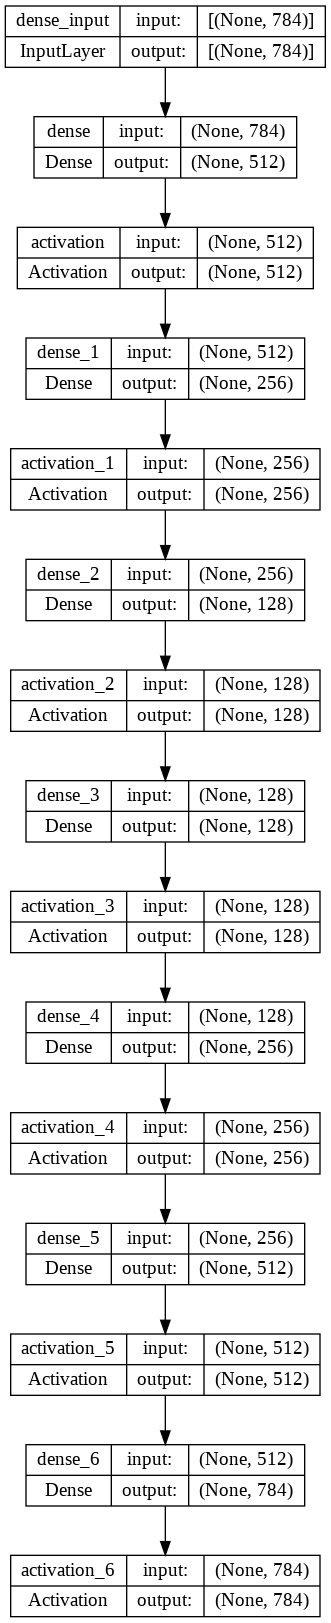

In [ ]:
# 위에서 정한 모델을 그림으로(plot) 보여줌
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# 모델 구조 확정하고 컴파일 진행
model.compile(loss='MSE',                   # MSE : mean square error
              optimizer='adam',                 
              metrics=[ 'mae' ])            # MAE : mean absolute  error  

# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(x_train, x_train,
                    batch_size=100,
                    epochs=100,
                    validation_data=(x_test, x_test),
                    shuffle=True)

Epoch 1/100
60/60 [==============================] - 3s 29ms/step - loss: 0.0753 - mae: 0.1581 - val_loss: 0.0438 - val_mae: 0.1016
Epoch 2/100
60/60 [==============================] - 2s 26ms/step - loss: 0.0373 - mae: 0.0914 - val_loss: 0.0315 - val_mae: 0.0803
Epoch 3/100
60/60 [==============================] - 2s 25ms/step - loss: 0.0280 - mae: 0.0742 - val_loss: 0.0248 - val_mae: 0.0674
Epoch 4/100
60/60 [==============================] - 1s 24ms/step - loss: 0.0219 - mae: 0.0619 - val_loss: 0.0196 - val_mae: 0.0561
Epoch 5/100
60/60 [==============================] - 2s 25ms/step - loss: 0.0176 - mae: 0.0523 - val_loss: 0.0164 - val_mae: 0.0498
Epoch 6/100
60/60 [==============================] - 2s 25ms/step - loss: 0.0152 - mae: 0.0473 - val_loss: 0.0151 - val_mae: 0.0475
Epoch 7/100
60/60 [==============================] - 1s 25ms/step - loss: 0.0135 - mae: 0.0438 - val_loss: 0.0135 - val_mae: 0.0431
Epoch 8/100
60/60 [==============================] - 1s 24ms/step - loss: 0.

## MSE function 구현

In [ ]:
def MSE(p, q):
  return np.mean((p - q)**2)

In [ ]:
test_score = model.evaluate(x_test, x_test, verbose=0)
prediction = model.predict(x_test)

31/31 [==============================] - 0s 6ms/step


## 0 이미지로만 구성된 test dataset을 활용하여 MSE 값 측정 + IQR

In [ ]:
MSE_loss = []
for i in range(len(x_test)):
  MSE_loss.append(MSE(x_test[i], prediction[i]))


print("MSE mean: ", np.mean(MSE_loss))
print("MSE variance: ", np.var(MSE_loss))
print("MSE standard deviation: ", np.std(MSE_loss))
mean_mse = np.mean(MSE_loss)
mean_lower_mse, mean_upper_mse = mean_mse - np.std(MSE_loss), mean_mse + np.std(MSE_loss)
print("mean_lower: ", mean_lower_mse)
print("mean_upper: ", mean_upper_mse)
print("MSE min: ", np.min(MSE_loss))
print("\n")

# IQR 계산
q25_mse = np.quantile(MSE_loss, 0.25)
q75_mse = np.quantile(MSE_loss, 0.75)
iqr_mse = q75_mse - q25_mse

cut_off_mse = iqr_mse*1.5
lower_mse, upper_mse = q25_mse - cut_off_mse, q75_mse + cut_off_mse
print("IQR: ", iqr_mse)
print("Lower: ", lower_mse)
print("Upper: ", upper_mse)
print("\n")                        

MSE mean:  0.00586880743976279
MSE variance:  1.177913580961735e-05
MSE standard deviation:  0.0034320745635282096
mean_lower:  0.00243673287623458
mean_upper:  0.009300882003291
MSE min:  0.0015651198569262765


IQR:  0.003301515024175965
Lower:  -0.0012442802301037294
Upper:  0.01196177986660013




## 0 이미지에 8 이미지 섞은 후, 8 이미지를 outlier로 잡는지 실험

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loss function: MSE

In [ ]:
outlier_score = model.evaluate(outlier_images, outlier_images, verbose=0) # loss 값 결과 확인

sample_size = len(outlier_images)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(outlier_images)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
File_name = []
Result = []
Loss = []

# mixed dataset내 각각의 data point마다 KLD loss를 구한다
MSE_data = []
for i in range(sample_size):
  MSE_data.append(MSE(outlier_images[i], prediction3[i]))

# 위에서 구한 KLD mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  File_name.append(files0_8_test[i])
  Loss.append(MSE_data[i])
  if MSE_data[i] < mean_upper_mse and MSE_data[i] > mean_lower_mse:
    Result.append(1)
  else:
    Result.append(0)

#print("--------------------------------------------------------\n")
data = {'file_name' : File_name, 
        'loss' : Loss, 
        'result' : Result}
data = pd.DataFrame(data)
#print(data)

# Confusion matrix
y_true = outlier_Y
y_pred = Result
confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("\n")

# csv file로 저장
#data.to_csv("drive/MyDrive/Hail_yeongmin/data/VAE_outlier_MSE.csv", mode='w', index = None)

32/32 [==============================] - 0s 6ms/step
Acc:  0.855
Precision:  0.998805256869773
Recall:  0.8530612244897959
F1 score:  0.9201981287837094
AUROC:  0.9015306122448979




## Loss function: MSE + IQR

In [ ]:
outlier_score = model.evaluate(outlier_images, outlier_images, verbose=0) # loss 값 결과 확인

sample_size = len(outlier_images)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(outlier_images)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
File_name = []
Result = []
Loss = []

# mixed dataset내 각각의 data point마다 KLD loss를 구한다
MSE_data = []
for i in range(sample_size):
  MSE_data.append(MSE(outlier_images[i], prediction3[i]))

# 위에서 구한 KLD mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  File_name.append(files0_8_test[i])
  Loss.append(MSE_data[i])
  if MSE_data[i] < upper_mse and MSE_data[i] > lower_mse:
    Result.append(1)
  else:
    Result.append(0)

#print("--------------------------------------------------------\n")
data = {'file_name' : File_name, 
        'loss' : Loss, 
        'result' : Result}
data = pd.DataFrame(data)
#print(data)

# Confusion matrix
y_true = outlier_Y
y_pred = Result
confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("\n")

# csv file로 저장
#data.to_csv("drive/MyDrive/Hail_yeongmin/data/VAE_outlier_MSE.csv", mode='w', index = None)

32/32 [==============================] - 0s 6ms/step
Acc:  0.952
Precision:  0.9989293361884368
Recall:  0.9520408163265306
F1 score:  0.9749216300940439
AUROC:  0.9510204081632653




## MSE 사용했을 때 결과 요약

216/216 [==============================] - 1s 7ms/step
Normal Metric
        Normal_mse
count  6903.000000
mean      0.004907
std       0.001760
min       0.001699
25%       0.003722
50%       0.004577
75%       0.005659
max       0.025663


31/31 [==============================] - 0s 7ms/step
Anomaly Metric
       Anomaly_mse
count   974.000000
mean      0.024406
std       0.007099
min       0.006662
25%       0.019715
50%       0.023547
75%       0.028143
max       0.064557




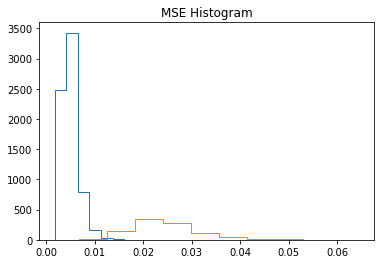

In [ ]:
import pandas as pd # pandas 라이브러리

# Normal data (data_3000)
Nom_data = np.concatenate((x_test, x_train), axis = 0)
Nom_pred = model.predict(Nom_data) # AE 이미지 결과값 
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse':Nom_pred_mse})
print(Nom_pred_mse_df.describe())

print('\n')

# Abnormal data (data_1000)
ANom_pred = model.predict(ANom_images) # AE 이미지 결과값 
ANom_pred_mse = np.mean(np.power(ANom_images - ANom_pred, 2), axis=1) # input - output 이미지간의 MSE 구하기

# 기초통계학 평균, 분산, 최소값, 최대값, 25%, 50%, 75% 분포 구하는 방법
print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

# 히스토그램 그리기
print('\n')
plt.figure()
plt.title('MSE Histogram') # 그림 이름 설정 
plt.hist(Nom_pred_mse, bins=10, facecolor='blue', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.hist(ANom_pred_mse, bins=10, facecolor='red', histtype='step') #히스토그램 함수, bins:데이터를 범주화 하는 기준
plt.show()